In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
                            GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score,  \
                                    StratifiedKFold, train_test_split


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler

In [23]:
df = pd.read_csv("https://raw.githubusercontent.com/marianwitkowski/python-data/master/titanic/titanic.csv")

# Ładowanie danych

In [24]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Sprawdźmy co z wartościami NaN

In [25]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Korelacja pomiędzy danymi

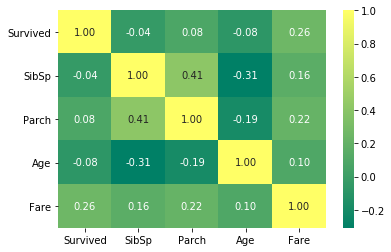

In [26]:
sns.heatmap(df[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                           annot=True, fmt = ".2f", cmap = "summer")
plt.show()

# Znajdowanie wartości odstających (outliers)

In [7]:
from collections import Counter
def detect_outliers_values(df,n,features):

    outlier_indices = []
    
    for col in features:   
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | 
                              (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
   
    outlier_indices = Counter(outlier_indices)  
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

# detect outliers: Age, SibSp, Parch, Fare
for_out = detect_outliers_values(df,2,["Age","SibSp","Parch","Fare"])
df = df.drop(for_out, axis = 0).reset_index(drop=True)

# Zmiana NaN w dla wieku

In [8]:
df.Age.replace(np.NaN, df["Age"].median(), inplace=True)

# Rozkład wieku osób ocalałych

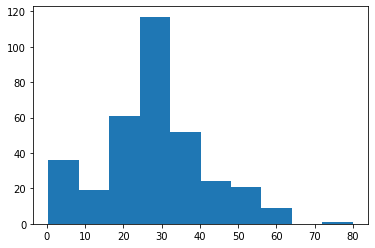

In [9]:
plt.hist(df[df.Survived==1].Age)
plt.show()

# Płeć osób ocalałych

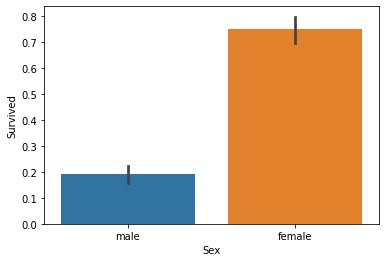

In [10]:
sns.barplot(x='Sex', y='Survived', data=df)
plt.show()


# Przekształcenia danych i zmiana do wartości kategorycznych

In [11]:
df.Embarked = df.Embarked.map({"S":0, "C":1, "Q":2})
df.Sex.replace(['male','female'], [0,1], inplace=True)

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(dataset_title)
df["Title"].replace(['Lady', 'the Countess',
                       'Capt', 'Col','Don', 'Dr', 
                       'Major', 'Rev', 'Sir', 'Jonkheer',
                       'Dona'], 'Rare', inplace=True)

df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                         "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, 
                                         "Rare":3})

df["Title"] = df["Title"].astype(int)

df["Famize"] = df["SibSp"] + df["Parch"] + 1
df.drop(labels = ["SibSp",'Parch'], axis = 1, inplace = True)

df.drop(labels = ["Ticket",'Cabin','PassengerId','Name'], axis = 1, inplace = True)
df.dropna(axis=0, how='any', inplace=True)

In [12]:
df.sample(n=10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Famize
831,1,1,0,28.0,29.7000,1.0,2,1
603,0,3,1,39.0,31.2750,0.0,1,7
564,1,1,1,53.0,51.4792,0.0,1,3
285,1,1,1,26.0,78.8500,0.0,1,1
194,1,3,1,28.0,7.7500,2.0,1,1
670,1,3,1,18.0,9.8417,0.0,1,1
142,0,2,0,18.0,11.5000,0.0,2,1
352,1,3,1,28.0,7.8792,2.0,1,1
9,1,2,1,14.0,30.0708,1.0,1,2
11,1,1,1,58.0,26.5500,0.0,1,1


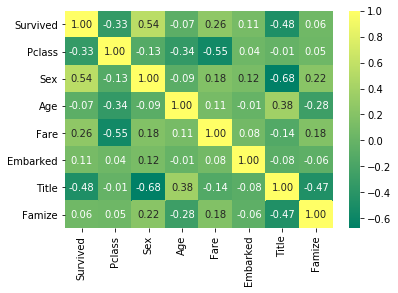

In [13]:
sns.heatmap(df.corr(), annot=True, fmt = ".2f", cmap = "summer")
plt.show()

# Podział na zmienne zależne i niezależną

In [14]:
X_train = df.iloc[:, 1:]
y_train = df["Survived"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
K_fold = StratifiedKFold(10)

# Uczenie estymatorów (bez przeskalowania danych)

In [15]:
random_state = 42

models = [] # append all models or predictive models 
cv_results = [] # cross validation result
cv_means = [] # cross validation mean value
cv_std = [] # cross validation standard deviation

models.append(KNeighborsClassifier())
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
models.append(SVC(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(LogisticRegression(random_state = random_state))
models.append(GaussianNB())
models.append(LinearDiscriminantAnalysis())
models.append(MLPClassifier(random_state=random_state))


for model in models :
    cv_results.append(cross_val_score(model, X_train, y_train, scoring = "accuracy", cv = K_fold, n_jobs=5))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

algos = ["KNeighboors",
         "DecisionTree",   
         "RandomForest",
         "ExtraTrees",
         "AdaBoost", 
         "SVC",
         "GradientBoosting",                      
         "LogisticRegression",
         "GaussianNaiveBayes",
         "LinearDiscriminantAnalysis",
         "MultipleLayerPerceptron"]

cv_frame1 = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValErrors": cv_std,
        "Algorithms": algos
})

In [16]:
cv_frame1.set_index('Algorithms', drop=True, inplace=True)
cv_frame1.sort_values('CrossValMeans', ascending=False)

,CrossValMeans,CrossValErrors
Algorithms,,
GradientBoosting,0.836155,0.044452
LinearDiscriminantAnalysis,0.819148,0.035219
LogisticRegression,0.815739,0.028446
RandomForest,0.808908,0.045840
MultipleLayerPerceptron,0.808908,0.037123
GaussianNaiveBayes,0.803226,0.042981
ExtraTrees,0.796408,0.048965
AdaBoost,0.790687,0.047386
DecisionTree,0.775901,0.046776


# Przy zastosowaniu skalera MinMaxScaler

In [17]:
X_train = MinMaxScaler().fit_transform(df.iloc[:, 1:])
y_train = df["Survived"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
K_fold = StratifiedKFold(10)

In [18]:
random_state = 42

models = [] # append all models or predictive models 
cv_results = [] # cross validation result
cv_means = [] # cross validation mean value
cv_std = [] # cross validation standard deviation

models.append(KNeighborsClassifier())
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
models.append(SVC(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(LogisticRegression(random_state = random_state))
models.append(GaussianNB())
models.append(LinearDiscriminantAnalysis())
models.append(MLPClassifier(random_state=random_state))


for model in models :
    cv_results.append(cross_val_score(model, X_train, y_train, scoring = "accuracy", cv = K_fold, n_jobs=5))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

algos = ["KNeighboors",
         "DecisionTree",   
         "RandomForest",
         "ExtraTrees",
         "AdaBoost", 
         "SVC",
         "GradientBoosting",                      
         "LogisticRegression",
         "GaussianNaiveBayes",
         "LinearDiscriminantAnalysis",
         "MultipleLayerPerceptron"]

cv_frame2 = pd.DataFrame({
        "CrossValMeans-Scaler":cv_means,
        "CrossValErrors-Scaler": cv_std,
        "Algorithms": algos
})

In [19]:
cv_frame2.set_index('Algorithms', drop=True, inplace=True)
cv_frame2.sort_values('CrossValMeans-Scaler', ascending=False)

,CrossValMeans-Scaler,CrossValErrors-Scaler
Algorithms,,
GradientBoosting,0.836155,0.044452
SVC,0.831661,0.039829
MultipleLayerPerceptron,0.827116,0.043825
LinearDiscriminantAnalysis,0.819148,0.035219
LogisticRegression,0.813454,0.034775
RandomForest,0.808908,0.045840
KNeighboors,0.808843,0.035319
GaussianNaiveBayes,0.803226,0.042981
ExtraTrees,0.796408,0.048965


In [20]:
df_result = pd.concat([cv_frame1,cv_frame2], axis=1)
df_result["CrossVallDiff"] = df_result["CrossValMeans-Scaler"] - df_result["CrossValMeans"]
df_result[["CrossValMeans","CrossValMeans-Scaler","CrossVallDiff"]].sort_values('CrossVallDiff', ascending=False)

,CrossValMeans,CrossValMeans-Scaler,CrossVallDiff
Algorithms,,,
SVC,0.682615,0.831661,0.149046
KNeighboors,0.715661,0.808843,0.093182
MultipleLayerPerceptron,0.808908,0.827116,0.018208
DecisionTree,0.775901,0.775901,0.000000
RandomForest,0.808908,0.808908,0.000000
ExtraTrees,0.796408,0.796408,0.000000
GradientBoosting,0.836155,0.836155,0.000000
GaussianNaiveBayes,0.803226,0.803226,0.000000
LinearDiscriminantAnalysis,0.819148,0.819148,0.000000
